# ECE 285 Assignment 1: Linear Regression

For this part of assignment, you are tasked to implement a linear regression algorithm for multiclass classification and test it on the CIFAR10 dataset.

You sould run the whole notebook and answer the questions in the notebook.

CIFAR 10 dataset contains 32x32x3 RGB images of 10 distinct cateogaries, and our aim is to predict which class the image belongs to

TO SUBMIT: PDF of this notebook with all the required outputs and answers.


In [79]:
# Prepare Packages
import numpy as np
import matplotlib.pyplot as plt

from ece285.utils.data_processing import get_cifar10_data

# Use a subset of CIFAR10 for the assignment
dataset = get_cifar10_data(
    subset_train=5000,
    subset_val=250,
    subset_test=500,
)

print(dataset.keys())
print("Training Set Data  Shape: ", dataset["x_train"].shape)
print("Training Set Label Shape: ", dataset["y_train"].shape)
print("Validation Set Data  Shape: ", dataset["x_val"].shape)
print("Validation Set Label Shape: ", dataset["y_val"].shape)
print("Test Set Data  Shape: ", dataset["x_test"].shape)
print("Test Set Label Shape: ", dataset["y_test"].shape)


dict_keys(['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test'])
Training Set Data  Shape:  (5000, 3072)
Training Set Label Shape:  (5000,)
Validation Set Data  Shape:  (250, 3072)
Validation Set Label Shape:  (250,)
Test Set Data  Shape:  (500, 3072)
Test Set Label Shape:  (500,)


In [80]:
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_val = dataset["x_val"]
y_val = dataset["y_val"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]


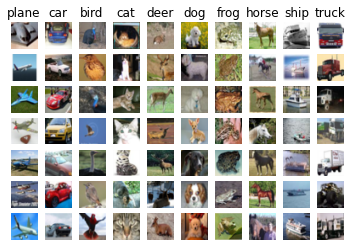

In [81]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
samples_per_class = 7


def visualize_data(dataset, classes, samples_per_class):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(dataset[idx])
            plt.axis("off")
            if i == 0:
                plt.title(cls)
    plt.show()


visualize_data(
    x_train.reshape(5000, 3, 32, 32).transpose(0, 2, 3, 1), classes, samples_per_class
)


# Linear Regression for multi-class classification


A Linear Regression Algorithm has 2 hyperparameters that you can experiment with:

- **Learning rate** - controls how much we change the current weights of the classifier during each update. We set it at a default value of 0.5, and later you are asked to experiment with different values. We recommend looking at the graphs and observing how the performance of the classifier changes with different learning rate.
- **Number of Epochs** - An epoch is a complete iterative pass over all of the data in the dataset. During an epoch we predict a label using the classifier and then update the weights of the classifier according the linear classifier update rule for each sample in the training set. We evaluate our models after every 10 epochs and save the accuracies, which are later used to plot the training, validation and test VS epoch curves.
- **Weight Decay** - Regularization can be used to constrain the weights of the classifier and prevent their values from blowing up. Regularization helps in combatting overfitting. You will be using the 'weight_decay' term to introduce regularization in the classifier.


### Implementation (50%)

You first need to implement the Linear Regression method in `algorithms/linear_regression.py`. You need to fill in the training function as well as the prediction function.


In [82]:
# Import the algorithm implementation (TODO: Complete the Linear Regression in algorithms/linear_regression.py)
from ece285.algorithms import Linear
from ece285.utils.evaluation import get_classification_accuracy

num_classes = 10  # Cifar10 dataset has 10 different classes

# Initialize hyper-parameters
learning_rate = 0.0001  # You will be later asked to experiment with different learning rates and report results
num_epochs_total = 1000  # Total number of epochs to train the classifier
epochs_per_evaluation = 10  # Epochs per step of evaluation; We will evaluate our model regularly during training
N, D = dataset["x_train"].shape  # Get training data shape, N: Number of examples, D:Dimensionality of the data
weight_decay = 0.0


In [83]:
# Insert additional scalar term 1 in the samples to account for the bias as discussed in class
x_train = np.insert(x_train, D, values=1, axis=1)
x_val = np.insert(x_val, D, values=1, axis=1)
x_test = np.insert(x_test, D, values=1, axis=1)

In [86]:
# Training and evaluation function -> Outputs accuracy data
def train(learning_rate_, weight_decay_):
    # Create a linear regression object
    linear_regression = Linear(
        num_classes, learning_rate_, epochs_per_evaluation, weight_decay_
    )

    # Randomly initialize the weights and biases
    weights = np.random.randn(num_classes, D + 1) * 0.0001

    train_accuracies, val_accuracies, test_accuracies = [], [], []

    # Train the classifier
    for _ in range(int(num_epochs_total / epochs_per_evaluation)):
        # Train the classifier on the training data
        weights = linear_regression.train(x_train, y_train, weights)

        # Evaluate the trained classifier on the training dataset
        y_pred_train = linear_regression.predict(x_train)
        train_accuracies.append(get_classification_accuracy(y_pred_train, y_train))

        # Evaluate the trained classifier on the validation dataset
        y_pred_val = linear_regression.predict(x_val)
        val_accuracies.append(get_classification_accuracy(y_pred_val, y_val))

        # Evaluate the trained classifier on the test dataset
        y_pred_test = linear_regression.predict(x_test)
        test_accuracies.append(get_classification_accuracy(y_pred_test, y_test))

    return train_accuracies, val_accuracies, test_accuracies, weights


### Plot the Accuracies vs epoch graphs


In [85]:
import matplotlib.pyplot as plt


def plot_accuracies(train_acc, val_acc, test_acc):
    # Plot Accuracies vs Epochs graph for all the three
    epochs = np.arange(0, int(num_epochs_total / epochs_per_evaluation))
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch/10")
    plt.plot(epochs, train_acc, epochs, val_acc, epochs, test_acc)
    plt.legend(["Training", "Validation", "Testing"])
    plt.show()


In [87]:
# Run training and plotting for default parameter values as mentioned above
t_ac, v_ac, te_ac, weights = train(learning_rate, weight_decay)


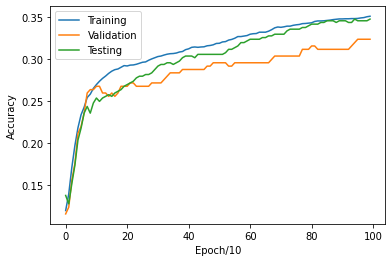

In [88]:
plot_accuracies(t_ac, v_ac, te_ac)


In [89]:
#check the ground truth
from sklearn.linear_model import LinearRegression

y_encode = np.zeros((N,10))
for i in range(10):
    a = np.array(y_train==i)
    y_encode[:,i] = 2*a-1 #{-1,1} encoding

predict_y = np.zeros((500,10))

for i in range(10):
    reg = LinearRegression()
    reg.fit(x_train,y_encode[:,i])
    predict_y[:,i] = reg.predict(x_test)

predict_label = np.argsort(predict_y,axis=1)[:,-1]
get_classification_accuracy(predict_label,y_test)


0.204

### Try different learning rates and plot graphs for all (20%)


c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:48: RuntimeWarning: overflow encountered in matmul
  grad = 2*X_train.T@(y_predict.T-y_encode)/N #DxN @ N*10
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:47: RuntimeWarning: invalid value encountered in matmul
  y_predict = self.w@X_train.T
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:49: RuntimeWarning: invalid value encountered in multiply
  self.w = self.w-(grad.T + self.weight_decay*self.w)*self.lr


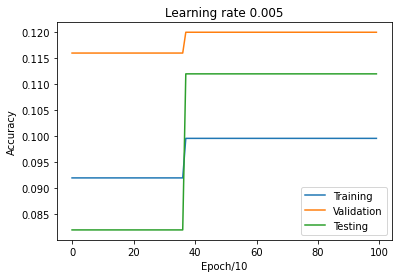

c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:48: RuntimeWarning: overflow encountered in matmul
  grad = 2*X_train.T@(y_predict.T-y_encode)/N #DxN @ N*10
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:47: RuntimeWarning: invalid value encountered in matmul
  y_predict = self.w@X_train.T
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:49: RuntimeWarning: invalid value encountered in multiply
  self.w = self.w-(grad.T + self.weight_decay*self.w)*self.lr


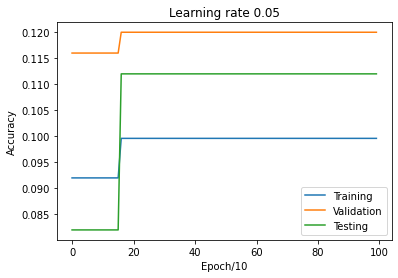

c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:48: RuntimeWarning: overflow encountered in matmul
  grad = 2*X_train.T@(y_predict.T-y_encode)/N #DxN @ N*10
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:47: RuntimeWarning: invalid value encountered in matmul
  y_predict = self.w@X_train.T
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:49: RuntimeWarning: invalid value encountered in multiply
  self.w = self.w-(grad.T + self.weight_decay*self.w)*self.lr


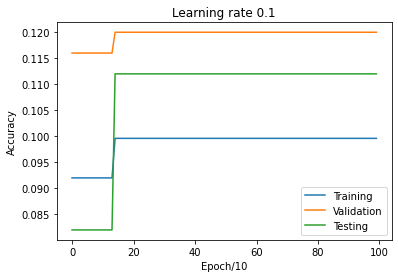

c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:48: RuntimeWarning: overflow encountered in matmul
  grad = 2*X_train.T@(y_predict.T-y_encode)/N #DxN @ N*10
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:47: RuntimeWarning: invalid value encountered in matmul
  y_predict = self.w@X_train.T
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:49: RuntimeWarning: invalid value encountered in multiply
  self.w = self.w-(grad.T + self.weight_decay*self.w)*self.lr


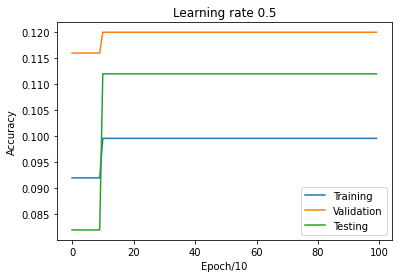

c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:48: RuntimeWarning: overflow encountered in matmul
  grad = 2*X_train.T@(y_predict.T-y_encode)/N #DxN @ N*10
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:47: RuntimeWarning: invalid value encountered in matmul
  y_predict = self.w@X_train.T
c:\Users\lizhu\Desktop\ece285\assignment1\ece285\algorithms\linear_regression.py:49: RuntimeWarning: invalid value encountered in multiply
  self.w = self.w-(grad.T + self.weight_decay*self.w)*self.lr


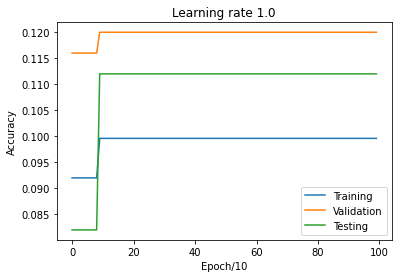

In [90]:
# TODO
# Repeat the above training and evaluation steps for the following learning rates and plot graphs
# You need to submit all 5 graphs along with this notebook pdf
learning_rates = [0.005, 0.05, 0.1, 0.5, 1.0]
weight_decay = 0.0  # No regularization for now

for i in learning_rates:
    t_ac, v_ac, te_ac, weights = train(i, weight_decay)
    plt.title('Learning rate {}'.format(i))
    plot_accuracies(t_ac, v_ac, te_ac)

    
# FEEL FREE TO EXPERIMENT WITH OTHER VALUES. REPORT OTHER VALUES IF THEY ACHIEVE A BETTER PERFORMANCE

# for lr in learning_rates: Train the classifier and plot data
# Step 1. train_accu, val_accu, test_accu = train(lr, weight_decay)
# Step 2. plot_accuracies(train_accu, val_accu, test_accu)


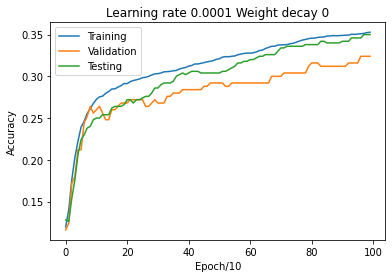

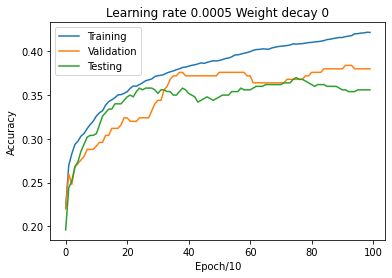

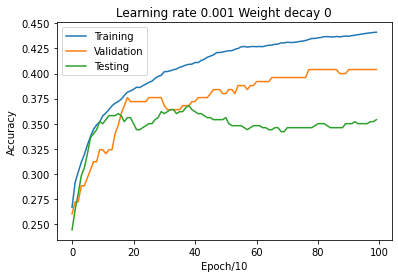

In [64]:
#my own try
learning_rates = [0.0001,0.0005,0.001]
weight_decay=[0]
for i in learning_rates:
    for j in weight_decay:
        t_ac, v_ac, te_ac, weights = train(i, j)
        plt.title('Learning rate {} Weight decay {}'.format(i,j))
        plot_accuracies(t_ac, v_ac, te_ac)

#### Inline Question 1.

Which one of these learning rates (best_lr) would you pick to train your model? Please Explain why.


#### Your Answer:
The best learning rate happens at 0.001. First, the learning rate larger than it cannot make the model converge, and doesnot help on training the data. Second, thr learning rate smaller than the model learns slower. In same number of epochs, leanrning rate = 0.001 achieves the best validation and test accuracy. 

It can be seen that around 400 epochs the model begins to overfit. Therefore a regulzarization is needed.

### Regularization: Try different weight decay and plot graphs for all (20%)


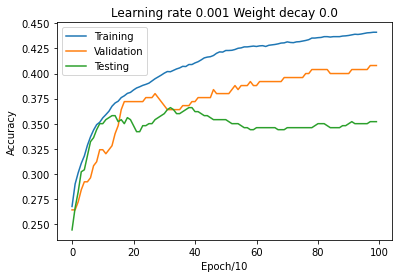

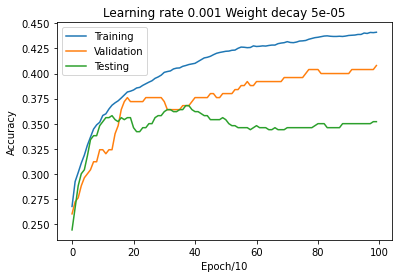

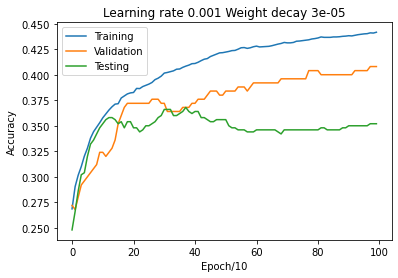

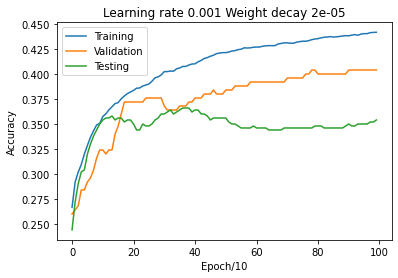

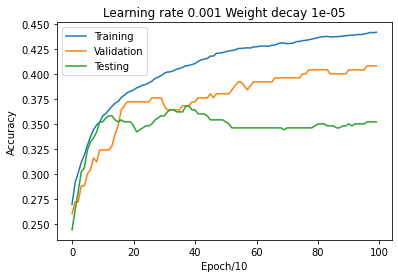

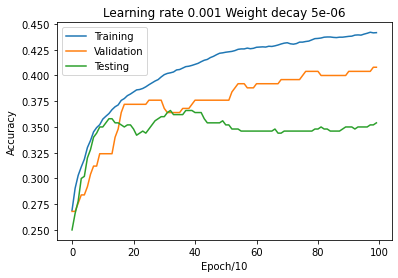

In [66]:
# Initialize a non-zero weight_decay (Regulzarization constant) term and repeat the training and evaluation
# Use the best learning rate as obtained from the above excercise, best_lr
weight_decays = [0.0, 0.00005, 0.00003, 0.00002, 0.00001, 0.000005]

# FEEL FREE TO EXPERIMENT WITH OTHER VALUES. REPORT OTHER VALUES IF THEY ACHIEVE A BETTER PERFORMANCE
i = 0.001
for j in weight_decays:
    t_ac, v_ac, te_ac, weights = train(i, j)
    plt.title('Learning rate {} Weight decay {}'.format(i,j))
    plot_accuracies(t_ac, v_ac, te_ac)


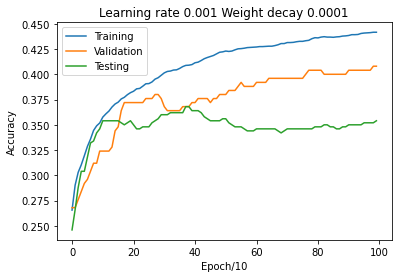

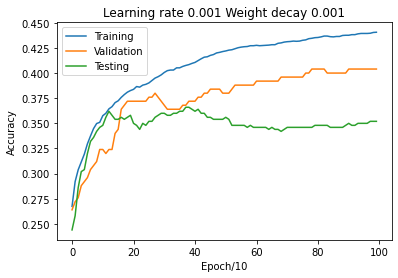

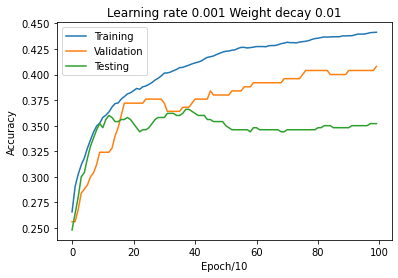

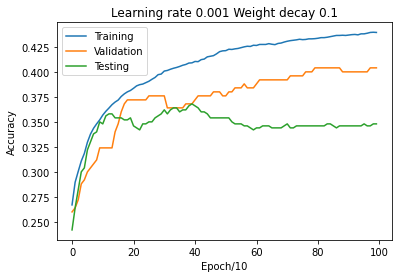

In [67]:
# My own try
weight_decays = [ 0.0001,0.001,0.01,0.1]

# FEEL FREE TO EXPERIMENT WITH OTHER VALUES. REPORT OTHER VALUES IF THEY ACHIEVE A BETTER PERFORMANCE
i=0.001
for j in weight_decays:
    t_ac, v_ac, te_ac, weights = train(i, j)
    plt.title('Learning rate {} Weight decay {}'.format(i,j))
    plot_accuracies(t_ac, v_ac, te_ac)

#### Inline Question 2.

Discuss underfitting and overfitting as observed in the 5 graphs obtained by changing the regularization.
Which weight_decay term gave you the best classifier performance?
HINT: Do not just think in terms of best training set performance, keep in mind that the real utility of a machine learning model is when it performs well on data it has never seen before


#### Your Answer:
All these 5 graphs have a higher accuracy in training set than the test set, and as the training accuracy increases, the testing accuracy decreases after a certain point. This shows that there is some overfitting. 
I think the best weight decay is 0.0001, because it has better validation accuracy and testing accuracy.

### Visualize the filters (10%)


The plot shows that the model is about to overfit around epoch 400. Therefore I choose epoch = 400 to train the model.

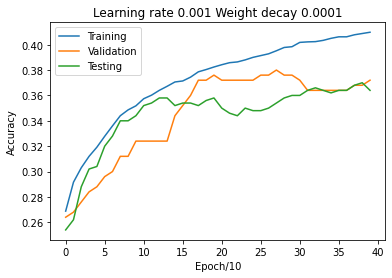

In [72]:
learning_rate = 0.001  # You will be later asked to experiment with different learning rates and report results
num_epochs_total = 400  # Total number of epochs to train the classifier
epochs_per_evaluation = 10  # Epochs per step of evaluation; We will evaluate our model regularly during training
weight_decay = 0.0001

t_ac, v_ac, te_ac, weights = train(learning_rate, weight_decay)
plt.title('Learning rate {} Weight decay {}'.format(learning_rate,weight_decay))
plot_accuracies(t_ac, v_ac, te_ac)

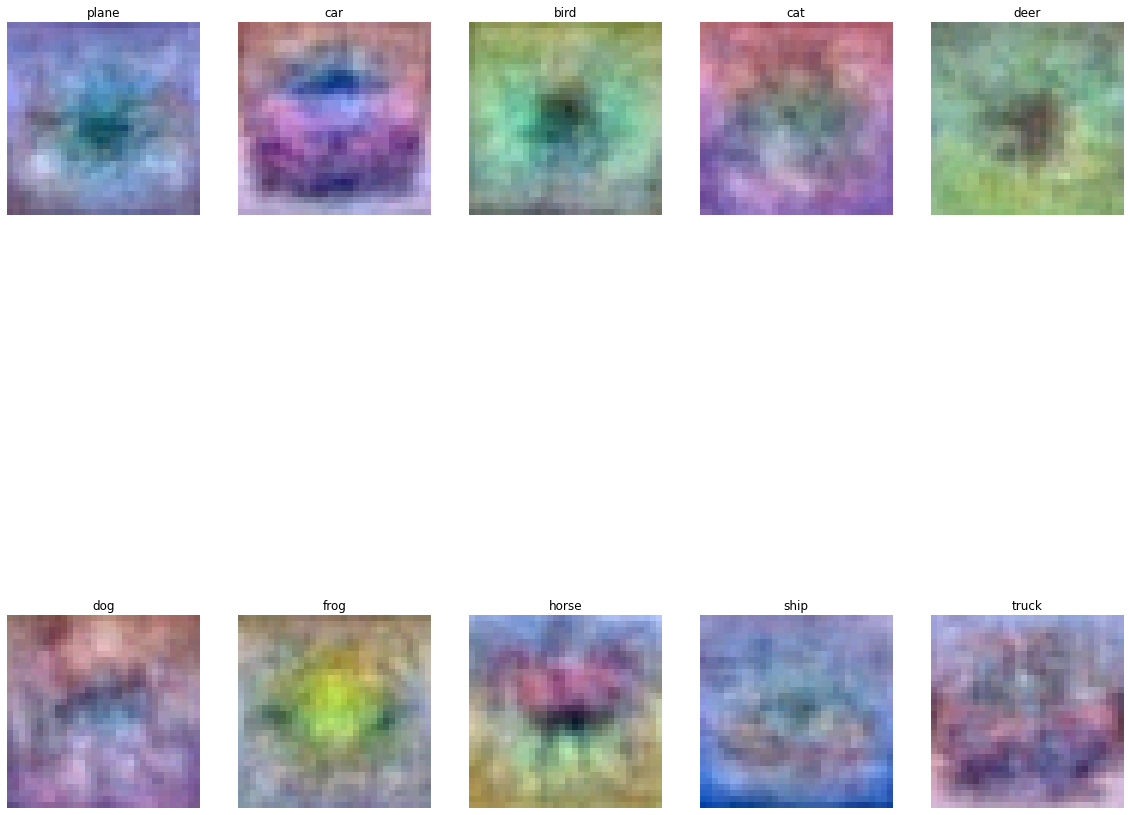

In [73]:
# These visualizations will only somewhat make sense if your learning rate and weight_decay parameters were
# properly chosen in the model. Do your best.


w = weights[:, :-1]
w = w.reshape(10, 3, 32, 32).transpose(0, 2, 3, 1)

w_min, w_max = np.min(w), np.max(w)

fig = plt.figure(figsize=(20, 20))
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
for i in range(10):
    fig.add_subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
    # plt.imshow(wimg.astype('uint8'))
    plt.imshow(wimg.astype(int))
    plt.axis("off")
    plt.title(classes[i])
plt.show()

# TODO: Run this cell and Show filter visualizations for the best set of weights you obtain.
# Report the 3 hyperparameters you used to obtain the best model.

# Be careful about choosing the 'weights' obtained from the correct trained classifier